# Urban Sound Classification(Chapter 2)

* Geçen bölümde UrbanSound8K verisetindeki ses dosyalarını spektrum görüntülerine çevirmiştik. 

* Daha sonra gri forma dönüştürme(grayscale dönüşümü), tüm resimleri (100,100) boyutuna getirme(resizing) ve tüm resimlerin piksel değerlerini maksimum piksel değerine(255) bölmüştük(normalizasyon).

* Daha sonra da tüm resimleri bir numpy array'ine toplamıştık(aynı şekilde etiketlerini de başka bir numpy array'ine toplamıştık).

* En sonunda da bu array'leri csv dosyalarına kaydetmiştik. Resim array'i çok büyük olduğu için bu array'i 20 parçaya ayırmış, 20 ayrı csv dosyasına kaydetmiştik.

* Şimdi kaydedilen csv dosyalarından resim ve etiket array'lerini elde edelim.

In [1]:
from google.colab import drive
import os
drive.mount("/content/drive")
os.chdir("/content/drive/My Drive/global_ai_hub")

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab.patches import cv2_imshow
import cv2

### "chapter1.ipynb" notebook'unda işleyip kaydettiğimiz verileri çekelim:

In [4]:
number_of_pieces=20
for i in range(number_of_pieces):
  file_name="images_csv_folder/images"+str(i)+".csv"
  flatten_X_piece = np.genfromtxt(file_name, delimiter=",")
  if i==0:
    flatten_X=flatten_X_piece
  else:
    flatten_X=np.concatenate((flatten_X,flatten_X_piece),axis=0)

In [5]:
y = np.genfromtxt("labels.csv", delimiter=",")

In [6]:
y=y.astype(int)

In [7]:
print(flatten_X.shape)

(8732, 10000)


### Birinci bölümde, üç boyutlu resim array'ini (8732, 100, 100) kaydedebilmek için iki boyuta getirmiştik (8732, 10000). Şimdi eğitimde kullanmak üzere; kaydettiğimiz yerden okuduğumuz iki boyutlu X array'ini tekrar üç boyutlu hale getirmemiz gerekiyor:

In [8]:
X= flatten_X.reshape(flatten_X.shape[0],int(np.sqrt(flatten_X.shape[1])),int(np.sqrt(flatten_X.shape[1])))

In [9]:
X.shape

(8732, 100, 100)

In [10]:
y.shape

(8732,)

* Artık veriyi train(%85), valid(%10), test(%5) olarak bölebiliriz. Bölme oranları istenildiği gibi oluşturulabilir.

In [11]:
train_per=0.85
val_per=0.1
test_per=0.05
total_size=len(X) #Elimizdeki toplam veri sayısı

# 0'dan başlayıp toplam veri sayısının %85'ine kadarki kısmı train için ayır. Aynı şeyi etiketleri için de yap.
X_train=X[:int(total_size*train_per)] 
y_train=y[:int(total_size*train_per)] 

# X'in %85'lik kısmının son elemanından başlayıp %95'lik kısmına kadar validasyon verisi için ayır. Aynı şeyi etiketleri için de yap.
X_val=X[int(total_size*train_per):int(total_size*(train_per+val_per))] 
y_val=y[int(total_size*train_per):int(total_size*(train_per+val_per))]

# X'in %95'lik kısmının son elemanından başlayıp X'in son elemanına kadar ayır. Aynı şeyi etiketleri için de yap.
X_test=X[int(total_size*(train_per+val_per)):]
y_test=y[int(total_size*(train_per+val_per)):]

* Bölme işlemi sonucu:

Train Veri Sayısı: 7422

Validasyon Veri Sayısı: 873

Test Veri Sayısı: 437

In [12]:
print(f"Len of X_train:{len(X_train)}")
print(f"Len of y_train:{len(y_train)}")
print(f"Len of X_val:{len(X_val)}")
print(f"Len of y_val:{len(y_val)}")
print(f"Len of X_test:{len(X_test)}")
print(f"Len of y_test:{len(y_test)}")

Len of X_train:7422
Len of y_train:7422
Len of X_val:873
Len of y_val:873
Len of X_test:437
Len of y_test:437


* Eğitim için kullanılacak X_train array'inin boyutu (3920, 100, 100) şeklinde. Bunun anlamı; X_train içinde (100,100) boyutunda 3920 adet resim var.

* y_train array'inin boyutu ise (3920,) şeklinde. Bunun anlamı; 3920 adet 0 boyutlu(bildiğimiz 3, 5 gibi sayılar) etiket var.

In [13]:
print(X_train.shape)
print(y_train.shape)
print("y_train'nin ilk 10 elemanı:")
print(y_train[0:10])

(7422, 100, 100)
(7422,)
y_train'nin ilk 10 elemanı:
[0 2 4 3 9 5 2 5 5 7]


## 3. Model Hazırlanması ve Eğitimi - Notebook
a. Bir CNN modeli hazırlayın.

b. Modeli hazırlamış olduğunuz veriyi kullanarak eğitin.

c. Modelin performans metriklerini, loss ve accuracy grafiklerini ekrana yazdırın.

d. Aldığınız sonuçlara göre hyperparameter optimization yapın.

In [14]:
# Konvolüsyon Katmanları:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="same",
                                 activation="relu",
                                 input_shape=(100,100,1))) # Ön İşlemede tüm resimleri sabit (100,100) yapmıştık. 1 ifadesi resimlerin gri olduğunu
model.add(tf.keras.layers.MaxPool2D((2,2)))                # belirtiyor.
model.add(tf.keras.layers.Conv2D(64,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="same",
                                 activation="relu"))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Conv2D(128,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="same",
                                 activation="relu"))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Conv2D(256,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="same",
                                 activation="relu"))
model.add(tf.keras.layers.MaxPool2D((2,2)))

#  Neural Network Katmanı:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dropout(0.81))
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dropout(0.81))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [15]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [16]:
results=model.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
58/58 [==============================] - 17s 79ms/step - loss: 2.1164 - accuracy: 0.1898 - val_loss: 1.7679 - val_accuracy: 0.3746
Epoch 2/20
58/58 [==============================] - 3s 58ms/step - loss: 1.6343 - accuracy: 0.3936 - val_loss: 1.3594 - val_accuracy: 0.5395
Epoch 3/20
58/58 [==============================] - 4s 61ms/step - loss: 1.3644 - accuracy: 0.5040 - val_loss: 1.2235 - val_accuracy: 0.6564
Epoch 4/20
58/58 [==============================] - 3s 58ms/step - loss: 1.1846 - accuracy: 0.5873 - val_loss: 0.9386 - val_accuracy: 0.6861
Epoch 5/20
58/58 [==============================] - 3s 58ms/step - loss: 0.9574 - accuracy: 0.6773 - val_loss: 0.7265 - val_accuracy: 0.7709
Epoch 6/20
58/58 [==============================] - 3s 58ms/step - loss: 0.8194 - accuracy: 0.7249 - val_loss: 0.6553 - val_accuracy: 0.7881
Epoch 7/20
58/58 [==============================] - 3s 58ms/step - loss: 0.6999 - accuracy: 0.7790 - val_loss: 0.5489 - val_accuracy: 0.8408
Epoch 8/20
5

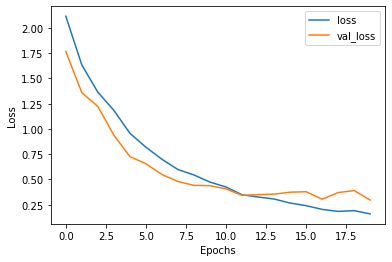

In [17]:
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

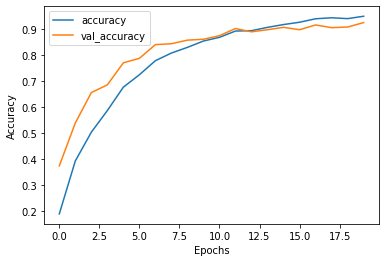

In [18]:
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [19]:
#Birinci eleman kaybı, ikinci eleman ise doğruluğu ifade ediyor.
model.evaluate(X_test, y_test)

14/14 [==============================] - 0s 15ms/step - loss: 0.2040 - accuracy: 0.9428


[0.20395511388778687, 0.942791759967804]

In [21]:
model.save("best_model.h5")

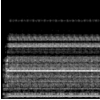

Label: 4
Prediction: 4
Prediction Probability: 99%


In [20]:
#Örnek Resim:
cv2_imshow(X_test[100]*255)
prediction_result=model.predict(X_test[100].reshape((1,100,100,1)))
prediction_result
predicted_class=prediction_result.argmax()
predicted_probability=prediction_result.max()

print("Label: "+str(y_test[100]))
print("Prediction: "+str(predicted_class))
print("Prediction Probability: "+str(int(predicted_probability*100))+"%")